# Basic EDA for Scraped Data

- The objective of this notebook is to conduct Exploratory Data Analysis on Scraped Data from multiple job portals in Singapore. Data was scraped using Dynamic Web Scraping technique. 
- Tools used to scrape:
  1. [scrapy](https://scrapy.org/),
  2. [selenium](https://www.selenium.dev/)

### Loading Data
- Load data from MongoDB Local host. 

In [1]:
import pandas as pd
from helper import read_mongo, display_pdseries_fw, plot_barh, plot_lineplot, render_wordcloud

db = 'ScraperProjects'
collection = 'job_scraper Data Scientist Singapore'

df = read_mongo(db,collection, no_id=True)
print(df.shape)
df.head(3)

(1235, 9)


,title,company,details,datePosted,employmentType,url,location,salary,classification
0,Data Engineer,JTE Recruit Pte Ltd,Our Client: Engineering Industry Central Regi...,2024-12-22T08:38:17.294Z,[FULL_TIME],https://sg.jobstreet.com/job/80956186?type=sta...,Central Region,"$5,500 – $8,000 per month",Database Development & Administration (Informa...
1,6 Months Data Scientist,HUDSON RPO (SINGAPORE) PTE. LTD.,We are seeking a talented and motivated Data S...,2024-12-20T09:49:06.484Z,[CONTRACTOR],https://sg.jobstreet.com/job/80938318?type=sta...,East Region,SGD 6500 per month,Business/Systems Analysts (Information & Commu...
2,Data Scientist,CPO PTE. LTD.,\nBe a part of our start-up where all decision...,2024-12-18T08:59:58.000Z,[FULL_TIME],https://sg.jobstreet.com/job/80897754?type=sta...,Singapore,None,"Mathematics, Statistics & Information Sciences..."


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           1235 non-null   object
 1   company         1235 non-null   object
 2   details         1235 non-null   object
 3   datePosted      1224 non-null   object
 4   employmentType  1235 non-null   object
 5   url             1235 non-null   object
 6   location        1218 non-null   object
 7   salary          105 non-null    object
 8   classification  1218 non-null   object
dtypes: object(9)
memory usage: 87.0+ KB


### 1. Top 10 Hiring Companies

- Looking through which companies are hiring the most.
- Annotated number indicates # of job posts by respective company.

Total # of companies: 435


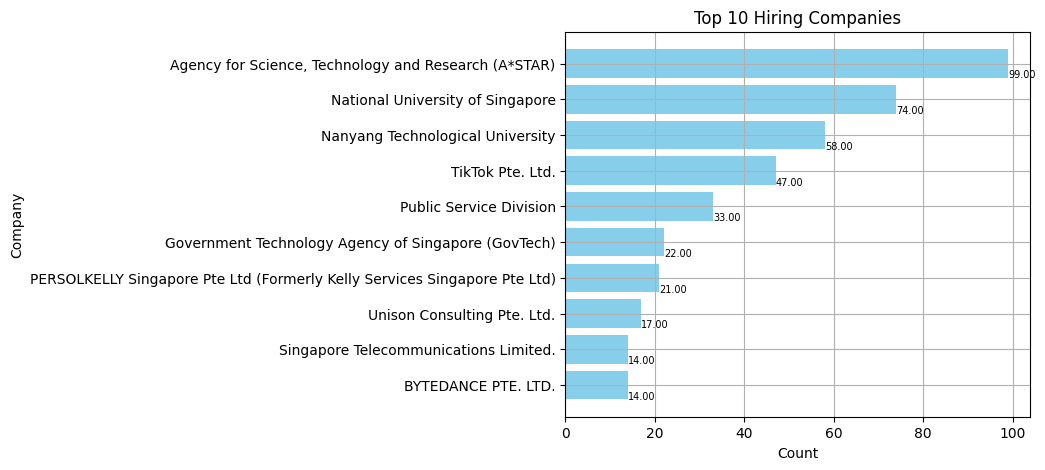

In [3]:
# count per companies
data = df['company'].value_counts(ascending=True)
print('Total # of companies: {}'.format(data.shape[0]))

# render top 10 companies
data = data[-10:]
plot_barh(data.keys(), data.values,"Count","Company","Top 10 Hiring Companies")

### 2. Top 10 Job Classifications

- Inspecting which fields have high demands.
- Annotated number indicates # of job posts in respective job classification.

Total # of job classifications: 86


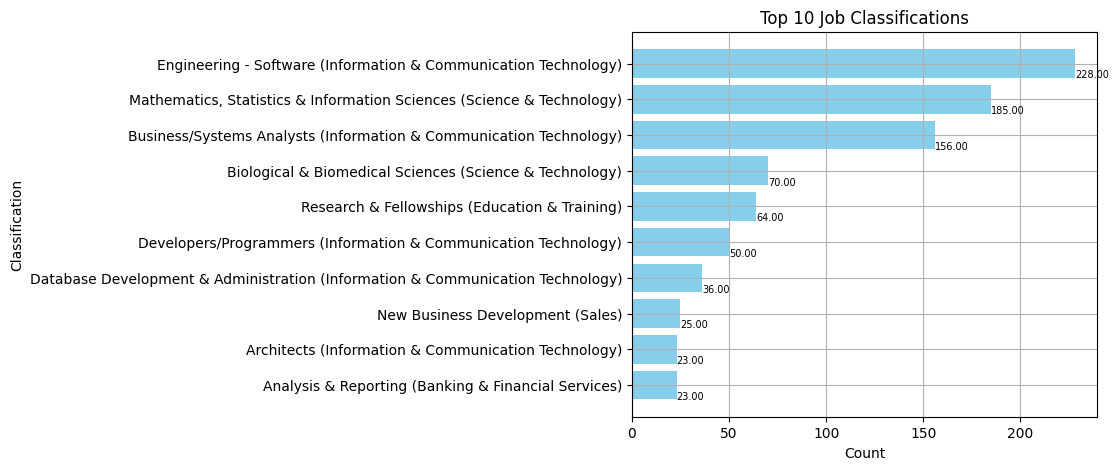

In [4]:
data = df['classification'].value_counts(ascending=True)
print('Total # of job classifications: {}'.format(data.shape[0]))

data = data[-10:]
plot_barh(data.keys(), data.values,"Count","Classification","Top 10 Job Classifications",figsize=(6, 5))

### 3. n-gram Analysis in Job Descriptions



##### Inspecting raw text

In [5]:
display_pdseries_fw(df['details'][0::50])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

#### 3.1. Text Cleaning

In [6]:
# Text cleaning
import re
import contractions

def clean_text(text):
    # convert contractions like 'I'm -> I am'
    text = contractions.fix(text)
    # remove url, email, non alphanumeric chars
    url = 'http\\S+|www\\S+'
    email = '\\S+@\\S+.\\S+'
    non_alphanum = '[^a-zA-Z0-9\\s]+|[(\n)]'
    unicode_space = '\xa0'
    text = re.sub(r'{}|{}|{}|{}'.format(url,email,non_alphanum, unicode_space), ' ', text)
    # remove meaningless patterns
    text = text.lower()
    patterns = ' e g |o\t' # e.g  becomes e g  after '.' removal
    text = re.sub(r'{}'.format(patterns), ' ', text).strip()
    # remove common strings
    common_strings = 'shortlist candidate notify|job description|shortlist candidate| key responsibilities'
    text = re.sub(r'{}'.format(common_strings), ' ', text).strip()
    multiple_spaces = '(\\s{2,})'
    return re.sub(r'{}'.format(multiple_spaces), ' ', text).strip()

df['details_cleaned'] = df['details'].apply(clean_text)
display_pdseries_fw(df['details_cleaned'][0::50])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

#### 3.2. Tokenization

- Stopwords removal and lemmatization are implemented. Experimented tokenization with and without lemmatization, lemmatization is better since it eliminates word inflections.
- Combined NLTK's stopwords list to spacy's stopwords because spacy lacks of some stopwords which exist in NLTK package.

In [7]:
#download spacy English small trained pipeline
!python -m spacy download en_core_web_sm 

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.0/12.8 MB 495.5 kB/s eta 0:00:26
      --------------------------------------- 0.2/12.8 MB 1.3 MB/s eta 0:00:10
      --------------------------------------- 0.2/12.8 MB 1.3 MB/s eta 0:00:11
     - -------------------------------------- 0.4/12.8 MB 1.7 MB/s eta 0:00:08
     - -------------------------------------- 0.5/12.8 MB 2.0 MB/s eta 0:00:06
     - -------------------------------------- 0.6/12.8 MB 2.1 MB/s eta 0:00:06
     -- ------------------------------------- 0.8/12.8 MB 2.4 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/12.8 MB 2.4 MB/s eta 0:00:06
     --- ------------------------------------ 1.1/12.8 MB 2.6 MB/s eta 0:00:05
     ---- ----------------------------------- 1.4/12.8 MB 2.9 MB/s eta 0:00:04
     ----- ---------------------------------- 1.6/12.8 MB


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import spacy
nlp = spacy.load('en_core_web_sm')

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

print("# of stopwords (spacy):{}".format(len(nlp.Defaults.stop_words)))
print("# of stopwords (nltk):{}".format(len(stopwords.words('english'))))

for sw in stopwords.words('english'):
    nlp.Defaults.stop_words.add(sw)
    nlp.vocab[sw].is_stop = True

print("# of stopwords (spacy) after combination:{}".format(len(nlp.Defaults.stop_words)))

# of stopwords (spacy):326
# of stopwords (nltk):179
# of stopwords (spacy) after combination:382


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def lemmatize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

def remove_stopwords(tokens):
    return " ".join(str(token) for token in tokens if(nlp.vocab[token].is_stop == False))
    # return [token for token in tokens if(nlp.vocab[token].is_stop == False)]

def preprocess(text, do_lemmatize=True):
    text = text.lower()
    tokens = lemmatize(text) if(do_lemmatize) else tokenize(text)
    tokens = remove_stopwords(tokens)
    return tokens

df['lemmas'] = df['details_cleaned'].apply(preprocess, do_lemmatize=True)
display_pdseries_fw(df['lemmas'][0::50])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

#### 3.4. Term Frequency
- CountVectorizer from Sklearn is used to extract term frequency (TF) of n-gram word.
- Experimented from uni-gram up to 4-gram. Apparently, 2-gram contributes meaningful observations.

(11423,)


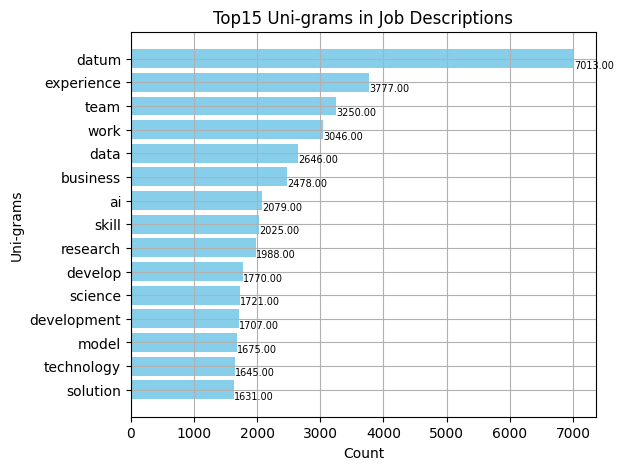

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def extract_sorted_termFreq(tokens, ngram_range):
    cv=CountVectorizer(analyzer='word', ngram_range=ngram_range)
    tf=cv.fit_transform(tokens)
    df_tf = pd.DataFrame(tf.toarray(), columns=cv.get_feature_names_out())
    df_tf_sorted = df_tf.sum().sort_values(ascending=True)
    return df_tf_sorted


df_tf_sorted = extract_sorted_termFreq(df['lemmas'], (1,1))
print(df_tf_sorted.shape)

data = df_tf_sorted[-15:]
plot_barh(data.keys(), data.values,"Count","Uni-grams","Top15 Uni-grams in Job Descriptions",figsize=(6, 5))

(119733,)


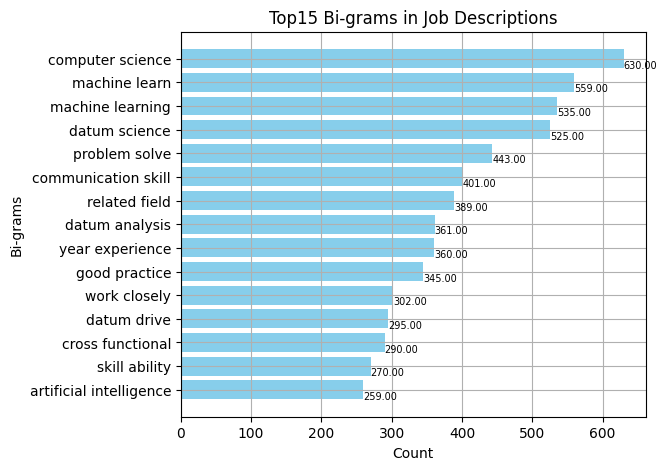

In [11]:
df_tf_sorted = extract_sorted_termFreq(df['lemmas'], (2,2))
print(df_tf_sorted.shape)

data = df_tf_sorted[-15:]
plot_barh(data.keys(), data.values,"Count","Bi-grams","Top15 Bi-grams in Job Descriptions",figsize=(6, 5))

(194517,)


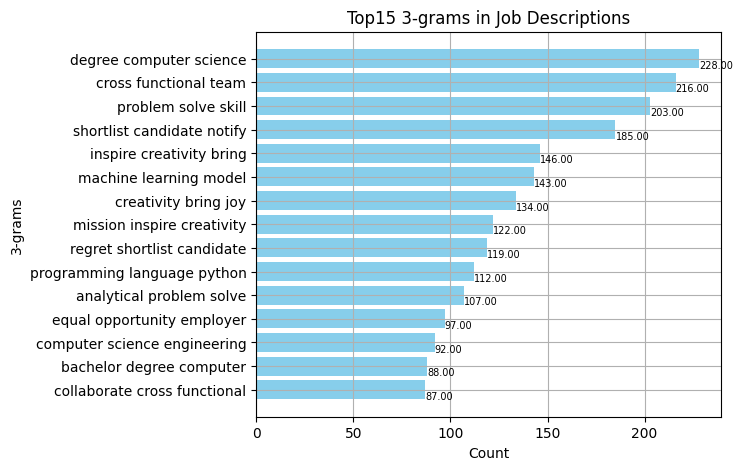

In [12]:
df_tf_sorted = extract_sorted_termFreq(df['lemmas'], (3,3))
print(df_tf_sorted.shape)

data = df_tf_sorted[-15:]
plot_barh(data.keys(), data.values,"Count","3-grams","Top15 3-grams in Job Descriptions",figsize=(6, 5))

(217228,)


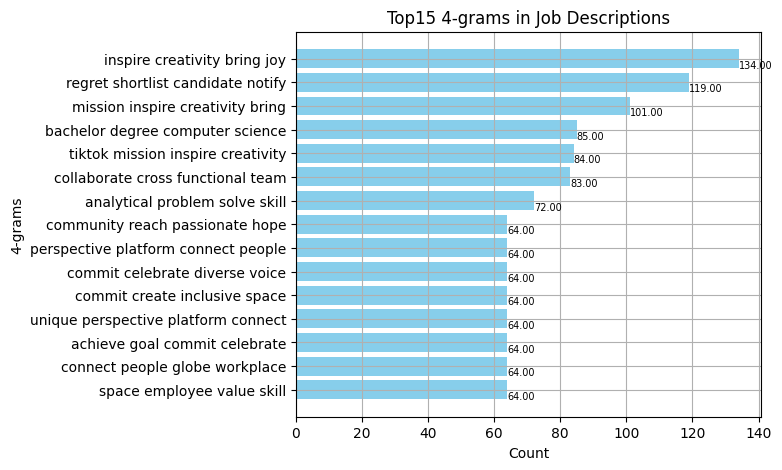

In [13]:
df_tf_sorted = extract_sorted_termFreq(df['lemmas'], (4,4))
print(df_tf_sorted.shape)

data = df_tf_sorted[-15:]
plot_barh(data.keys(), data.values,"Count","4-grams","Top15 4-grams in Job Descriptions",figsize=(6, 5))

#### 3.5. Wordcloud
- Genearte wordcloud from bi-gram, 3-gram and 4-gram.

(531478,)


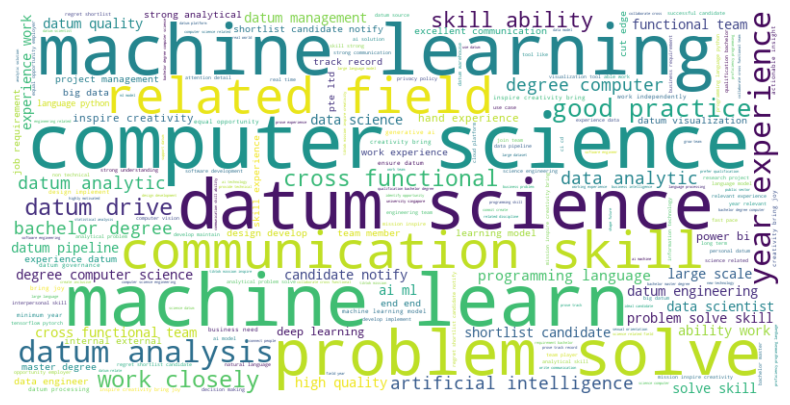

In [14]:
df_tf_sorted = extract_sorted_termFreq(df['lemmas'], (2,4))
print(df_tf_sorted.shape)

render_wordcloud(df_tf_sorted)

### 4. Others

##### 4.1. # of Job Posts per Weekday

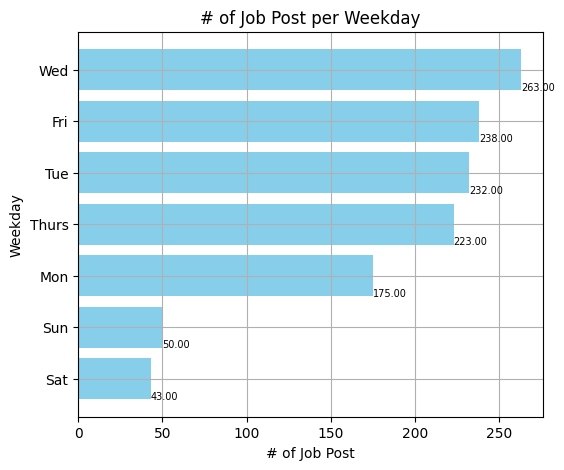

In [15]:
import datetime

def get_weekday(datePosted):
    if(not datePosted): return None
    dt = datetime.datetime.strptime(datePosted, '%Y-%m-%d')
    wkMap = {0: 'Mon',1: 'Tue',2: 'Wed',3: 'Thurs',4: 'Fri',5: 'Sat',6: 'Sun'}
    return wkMap[dt.weekday()]

df['weekdayPosted'] = df['datePosted'].str.slice(stop=10).apply(get_weekday)
# df['hourPosted'] = df['datePosted'].str.slice(start=11, stop=13)

data = df['weekdayPosted'].value_counts(ascending=True)
plot_barh(data.keys(), data.values,"# of Job Post","Weekday","# of Job Post per Weekday")

##### 4.2. # of Job Posts in 24 Hours 

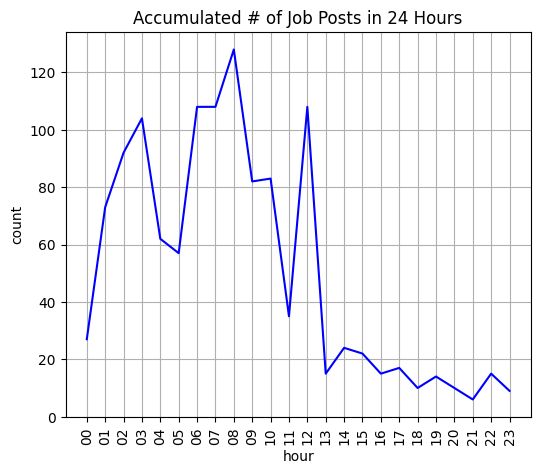

In [16]:
df['hour'] = df['datePosted'].str.slice(start=11, stop=13)
data = df['hour'].value_counts().reset_index().sort_values('hour')
plot_lineplot(data,'hour','count', 'Accumulated # of Job Posts in 24 Hours', color='blue')

##### 4.3. Top 20 Locations

Total # of locations: 72


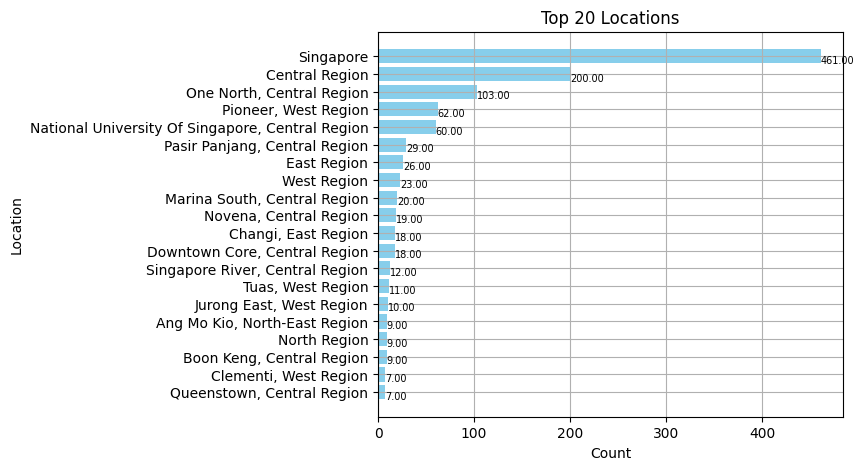

In [17]:
data = df['location'].value_counts(ascending=True)
print('Total # of locations: {}'.format(data.shape[0]))

data = data[-20:]
plot_barh(data.keys(), data.values,"Count","Location","Top 20 Locations")

##### 4.4. Employment Types 

In [18]:
data = df['employmentType'].value_counts(ascending=False)
data

employmentType
[FULL_TIME]                           1073
[CONTRACTOR]                           101
[CONTRACTOR, FULL_TIME]                 22
[PART_TIME]                             11
Full time                               11
[FULL_TIME, PART_TIME]                   5
[OTHER]                                  5
[PER_DIEM, FULL_TIME]                    2
[FULL_TIME, CONTRACTOR]                  1
[CONTRACTOR, PER_DIEM, PART_TIME]        1
[PER_DIEM]                               1
[CONTRACTOR, FULL_TIME, PART_TIME]       1
[PER_DIEM, FULL_TIME, PART_TIME]         1
Name: count, dtype: int64